In [1]:
import cv2
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d
from tqdm import tqdm

In [ ]:
revchecker_nc = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021721/EE11P11LT/hf4_revchecker/021721_EE11P11LT_control_Rig2_hf4_revchecker_world.nc'
revchecker_bin = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021721/EE11P11LT/hf4_revchecker/021721_EE11P11LT_control_Rig2_hf4_revchecker_Ephys.bin'
revchecker_ephys_json = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021721/EE11P11LT/hf4_revchecker/021721_EE11P11LT_control_Rig2_hf4_revchecker_ephys_merge.json'

In [2]:
revchecker_nc = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021621/EE11P1LT/hf4_revchecker/021621_EE11P1LT_control_Rig2_hf4_revchecker_world.nc'
revchecker_bin = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021621/EE11P1LT/hf4_revchecker/021621_EE11P1LT_control_Rig2_hf4_revchecker_Ephys.bin'
revchecker_ephys_json = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/021621/EE11P1LT/hf4_revchecker/021621_EE11P1LT_control_Rig2_hf4_revchecker_ephys_merge.json'

In [3]:
def read_ephys_bin(binpath, ch_num, do_remap=True):
    if ch_num!=16 and ch_num!=64:
        print('not 16 or 64 ch probe -- check arg ch_num')
        return None
    if ch_num == 16:
        ch_remap = [15,18,10,23,11,22,12,21,9,24,13,20,14,19,16,17] - 8
        dtypes = np.dtype([("ch"+str(i),np.uint16) for i in range(0,16)])
    elif ch_num == 64:
        ch_remap = [32,62,33,63,34,60,36,61,37,58,38,59,40,56,41,57,42,54,44,55,
                    45,52,46,53,47,50,43,51,39,48,35,49,0,30,1,31,2,28,3,26,4,27,
                    5,24,6,22,7,23,8,20,9,18,10,19,11,16,12,17,13,21,14,25,15,29]
        dtypes = np.dtype([("ch"+str(i),np.uint16) for i in range(0,64)])
    # read in binary file
    ephys = pd.DataFrame(np.fromfile(binpath, dtypes, -1, ''))
    # remap with known order of channels
    if do_remap is True:
        ephys = ephys.iloc[:,list(ch_remap)]
    return ephys

In [4]:
ephys = read_ephys_bin(revchecker_bin, 64)

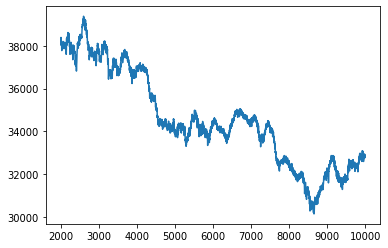

In [5]:
plt.plot(ephys.iloc[2000:10000,0])

In [6]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def low_pass_ephys_filt(ephys):
    order = 6
    fs = 300000 # Hz
    cutoff = 300 # Hz
    filt_ephys = butter_lowpass_filter(ephys, cutoff, fs, order)
    
    return filt_ephys

In [7]:
filt_ephys = low_pass_ephys_filt(ephys)

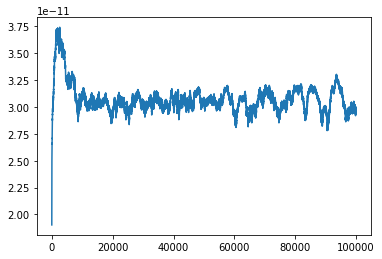

In [8]:
plt.plot(filt_ephys[0:100000,0])

In [9]:
world = xr.open_dataset(revchecker_nc)

In [10]:
world_vid = world.WORLD_video.astype(np.uint8)

In [11]:
# get 3d diff between consecutive frames
def world_diff(world_vid):
    for step in tqdm(range(np.size(world_vid,0)-1)):
        frame = world_vid[step]
        next_frame = world_vid[step+1]
        diff = frame - next_frame
        if step == 0:
            all_diff = diff
        else:
            all_diff = np.dstack([all_diff, diff])
    return all_diff

In [12]:
full_diff = world_diff(world_vid)

100%|██████████| 7880/7880 [02:24<00:00, 54.47it/s] 


In [13]:
# get the sum of pixel-by-pixel differences for each frame in x and y
sum_diff = []
for step in tqdm(range(np.size(full_diff,2))):
    frame = full_diff[:,:,step]
    sum_diff.append(np.sum(frame))

100%|██████████| 7880/7880 [00:00<00:00, 16703.66it/s]


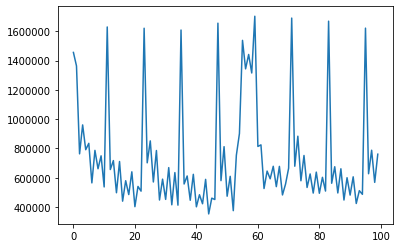

In [14]:
plt.plot(sum_diff[:100])

In [15]:
sum_diff_arr = np.array(sum_diff)
revframes = sum_diff_arr>1500000

(array([ 68.,   2.,  24.,   3.,  21.,   0.,  30.,   0.,  30., 580.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

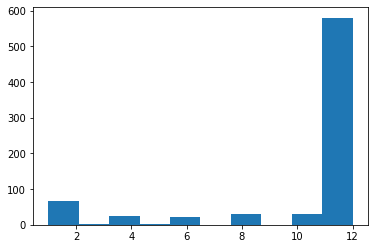

In [121]:
plt.hist(np.diff(np.where(revframes>0)).T)

In [16]:
ephys_data = pd.read_json(revchecker_ephys_json)
ephysT0 = ephys_data.iloc[0,12]
worldT = world.WORLD_times.values - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60

In [17]:
dt = 0.025
t = np.arange(0, np.max(worldT),dt)

In [18]:
samprate = 30000

In [20]:
all_resp = np.zeros([np.size(filt_ephys, 1), np.sum(revframes), len(list(set(np.arange(1-0.1, 1+0.5, 1/samprate))))])
true_rev_index = 0
for rev_ind, rev_label in tqdm(enumerate(revframes)):
    if rev_label == True:
        ephys_ind = (rev_ind*samprate)/60
        wc_time = worldT[rev_ind]
        for ch_num in range(np.size(filt_ephys, 1)):
            bin_start = int((wc_time-(0.1*samprate)); bin_end = int((wc_time+(0.5*samprate))
            if bin_start > 0 and bin_end < np.size(filt_ephys, 0):
                all_resp[ch_num, true_rev_index] = filt_ephys[bin_start:bin_end, ch_num]
        true_rev_index = true_rev_index + 1

7880it [00:04, 1804.89it/s]


In [23]:
rev_resp_mean = np.mean(all_resp, 1)

In [24]:
np.shape(rev_resp_mean)

(64, 18000)

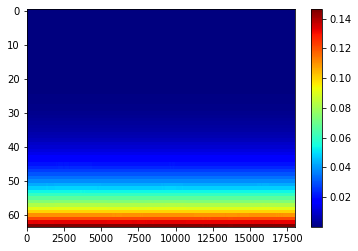

In [28]:
plt.imshow(rev_resp_mean, aspect='auto', cmap='jet')
plt.colorbar()

In [46]:
rev_resp_norm = 2.*(rev_resp_mean - rev_resp_mean.min(axis=1, keepdims=True))/np.ptp(rev_resp_mean, axis=0, keepdims=True)-1

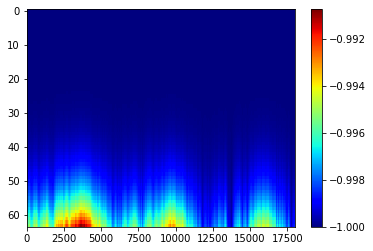

In [47]:
plt.imshow(rev_resp_norm, aspect='auto', cmap='jet')
plt.colorbar()

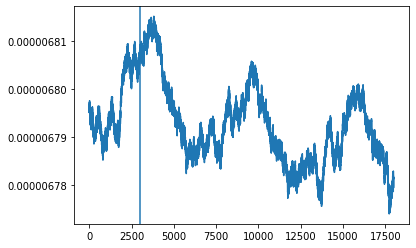

In [23]:
plt.plot(rev_resp_mean[11])
plt.axvline(x=0.1*samprate)

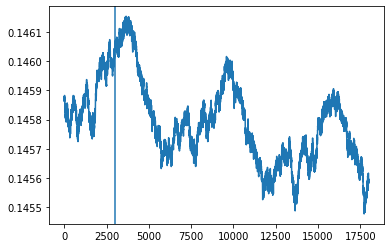

In [24]:
plt.plot(rev_resp_mean[63])
plt.axvline(x=0.1*samprate)

In [106]:
np.shape(all_resp)

(64, 759, 18000)

(0.125, 0.18)

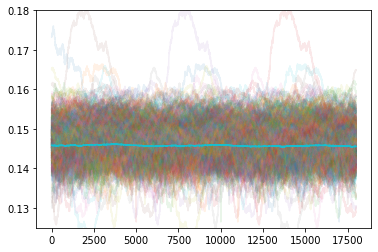

In [111]:
for inst_of_resp in range(0,np.size(all_resp, 1)):
    plt.plot(all_resp[63, inst_of_resp, :], alpha=0.1)
plt.plot(rev_resp_mean[63])
plt.ylim([0.125, 0.180])

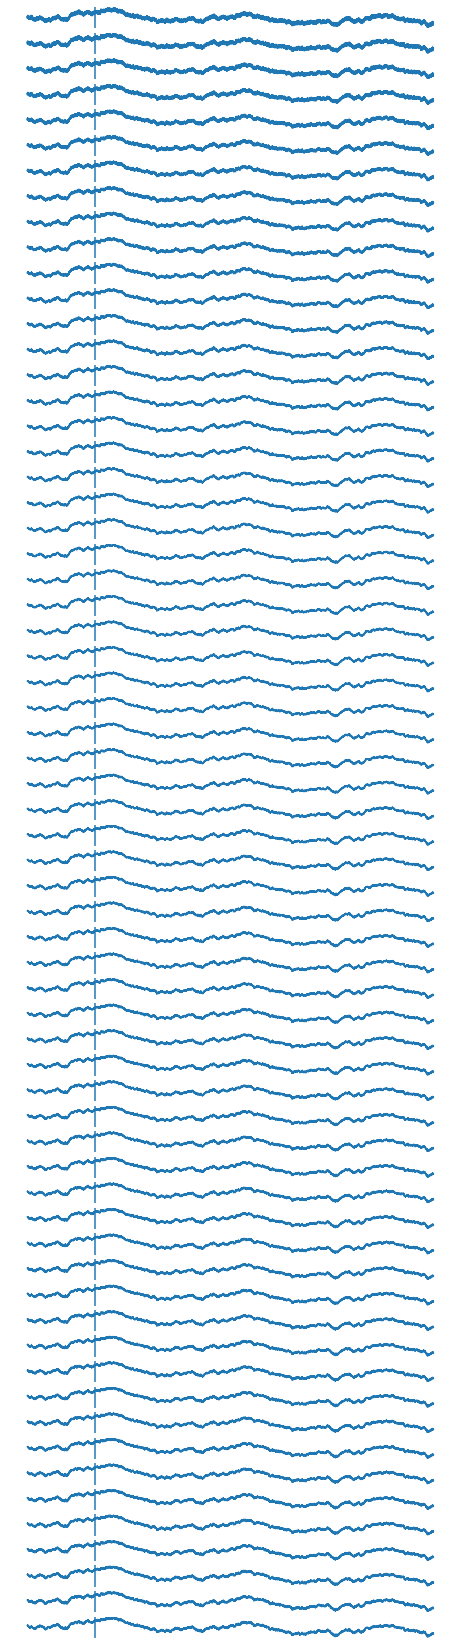

In [105]:
offset = 1.5
plt.subplots(64,1, figsize=(8,30))
for ch_num in range(0,64):
    plt.subplot(64,1, ch_num+1)
    plt.plot(rev_resp_mean[ch_num])
    plt.axvline(x=0.1*samprate)
    plt.axis('off')
plt.show()